# Decison Tree Classifier for Classifying Music Emotions
---
## About the Dataset

For this experiment, our dataset contains 267 music samples that were labelled by 2 music experts. The dataset has a combination of high level and low level features. The high level features are tempo, arousal, and scale, which were all labelled by the music experts. The low level features were extracted from the music samples using the JAudio software.

---
## Libraries

We used the pandas and csv libraries to load the dataset, which is a csv file. Then we used numpy to manipulate the loaded dataset. We used the sci kit learn library for the decision tree algorithm.

In [3]:
import os
import numpy as np
import pandas as pd
import csv
from sklearn import tree
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from scipy.stats import uniform, norm
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import plot_confusion_matrix
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE, RandomOverSampler
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from XLB import *

import warnings
warnings.filterwarnings('ignore')

Here we load the data from the csv file and preprocess it by removing the header row and the filename column

After the initial preprocessing step, we sperated the music features and the labelled emotion into the x_train and y_train arrays respectively

In [4]:
x_train, y_train = extract_data("TrainingSet (Labeled Only).csv")
scaler = MinMaxScaler()
scaler.fit(x_train)
x_train = scaler.transform(x_train)

(246, 327)
(246, 324)
(246,)


Here we perform different methods to deal with imbalanced datasets. We used the oversampling *Insert link to oversampling if needed* and SMOTE methodology *Insert link to SMOTE if needed*

In [5]:
rand_seed = 3454132

oversampler = SMOTE(sampling_strategy="not majority",random_state=rand_seed)

x_smote, y_smote = oversampler.fit_resample(x_train,y_train)

print(x_smote.shape,y_smote.shape)

oversampler = RandomOverSampler(sampling_strategy="not majority",random_state=rand_seed)

x_os, y_os = oversampler.fit_resample(x_train,y_train)

print(x_os.shape,y_os.shape)

(456, 324) (456,)
(456, 324) (456,)


Here we defined a function that will train the model and perform the hyperparameter search. x_train is the input data, y_train is the labels for the input data, and hp_search is the algorithm for hyperparameter search

This function trains the model, using the previously defined train_model function, and displays the confusion matrix of the model. 

The following cells are the experiments we ran with the default dataset, oversampled version, and SMOTE version using random search as the hyperparameter search algorithm

---
This cell instantiates the decison tree object and the hyperparameter search object.

In [6]:
#DecisionTree
random_search_iterations = 1000
n_splits = 5
rand_seed = 3249807

parameters = {
    'criterion':["gini", "entropy"], 
    'splitter':["best", "random"], 
    'max_depth':range(1, 10), 
    'min_samples_split':uniform(loc=0,scale=1.0)
}

# train classifier for SMOTE data
dt = tree.DecisionTreeClassifier()
rscv = RandomizedSearchCV(dt, parameters,cv=n_splits, random_state=rand_seed, n_iter=random_search_iterations,n_jobs=-1)

This model is trained using the default 

Vanilla:
Best Score: 0.3504
criterion => entropy
max_depth => 8
min_samples_split => 0.15983127030480682
splitter => random
Splits: 5
Accuracy: 45.9350%


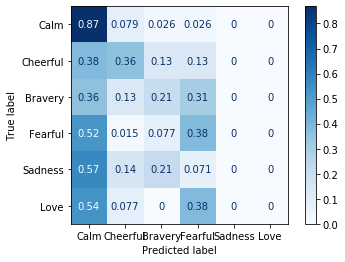

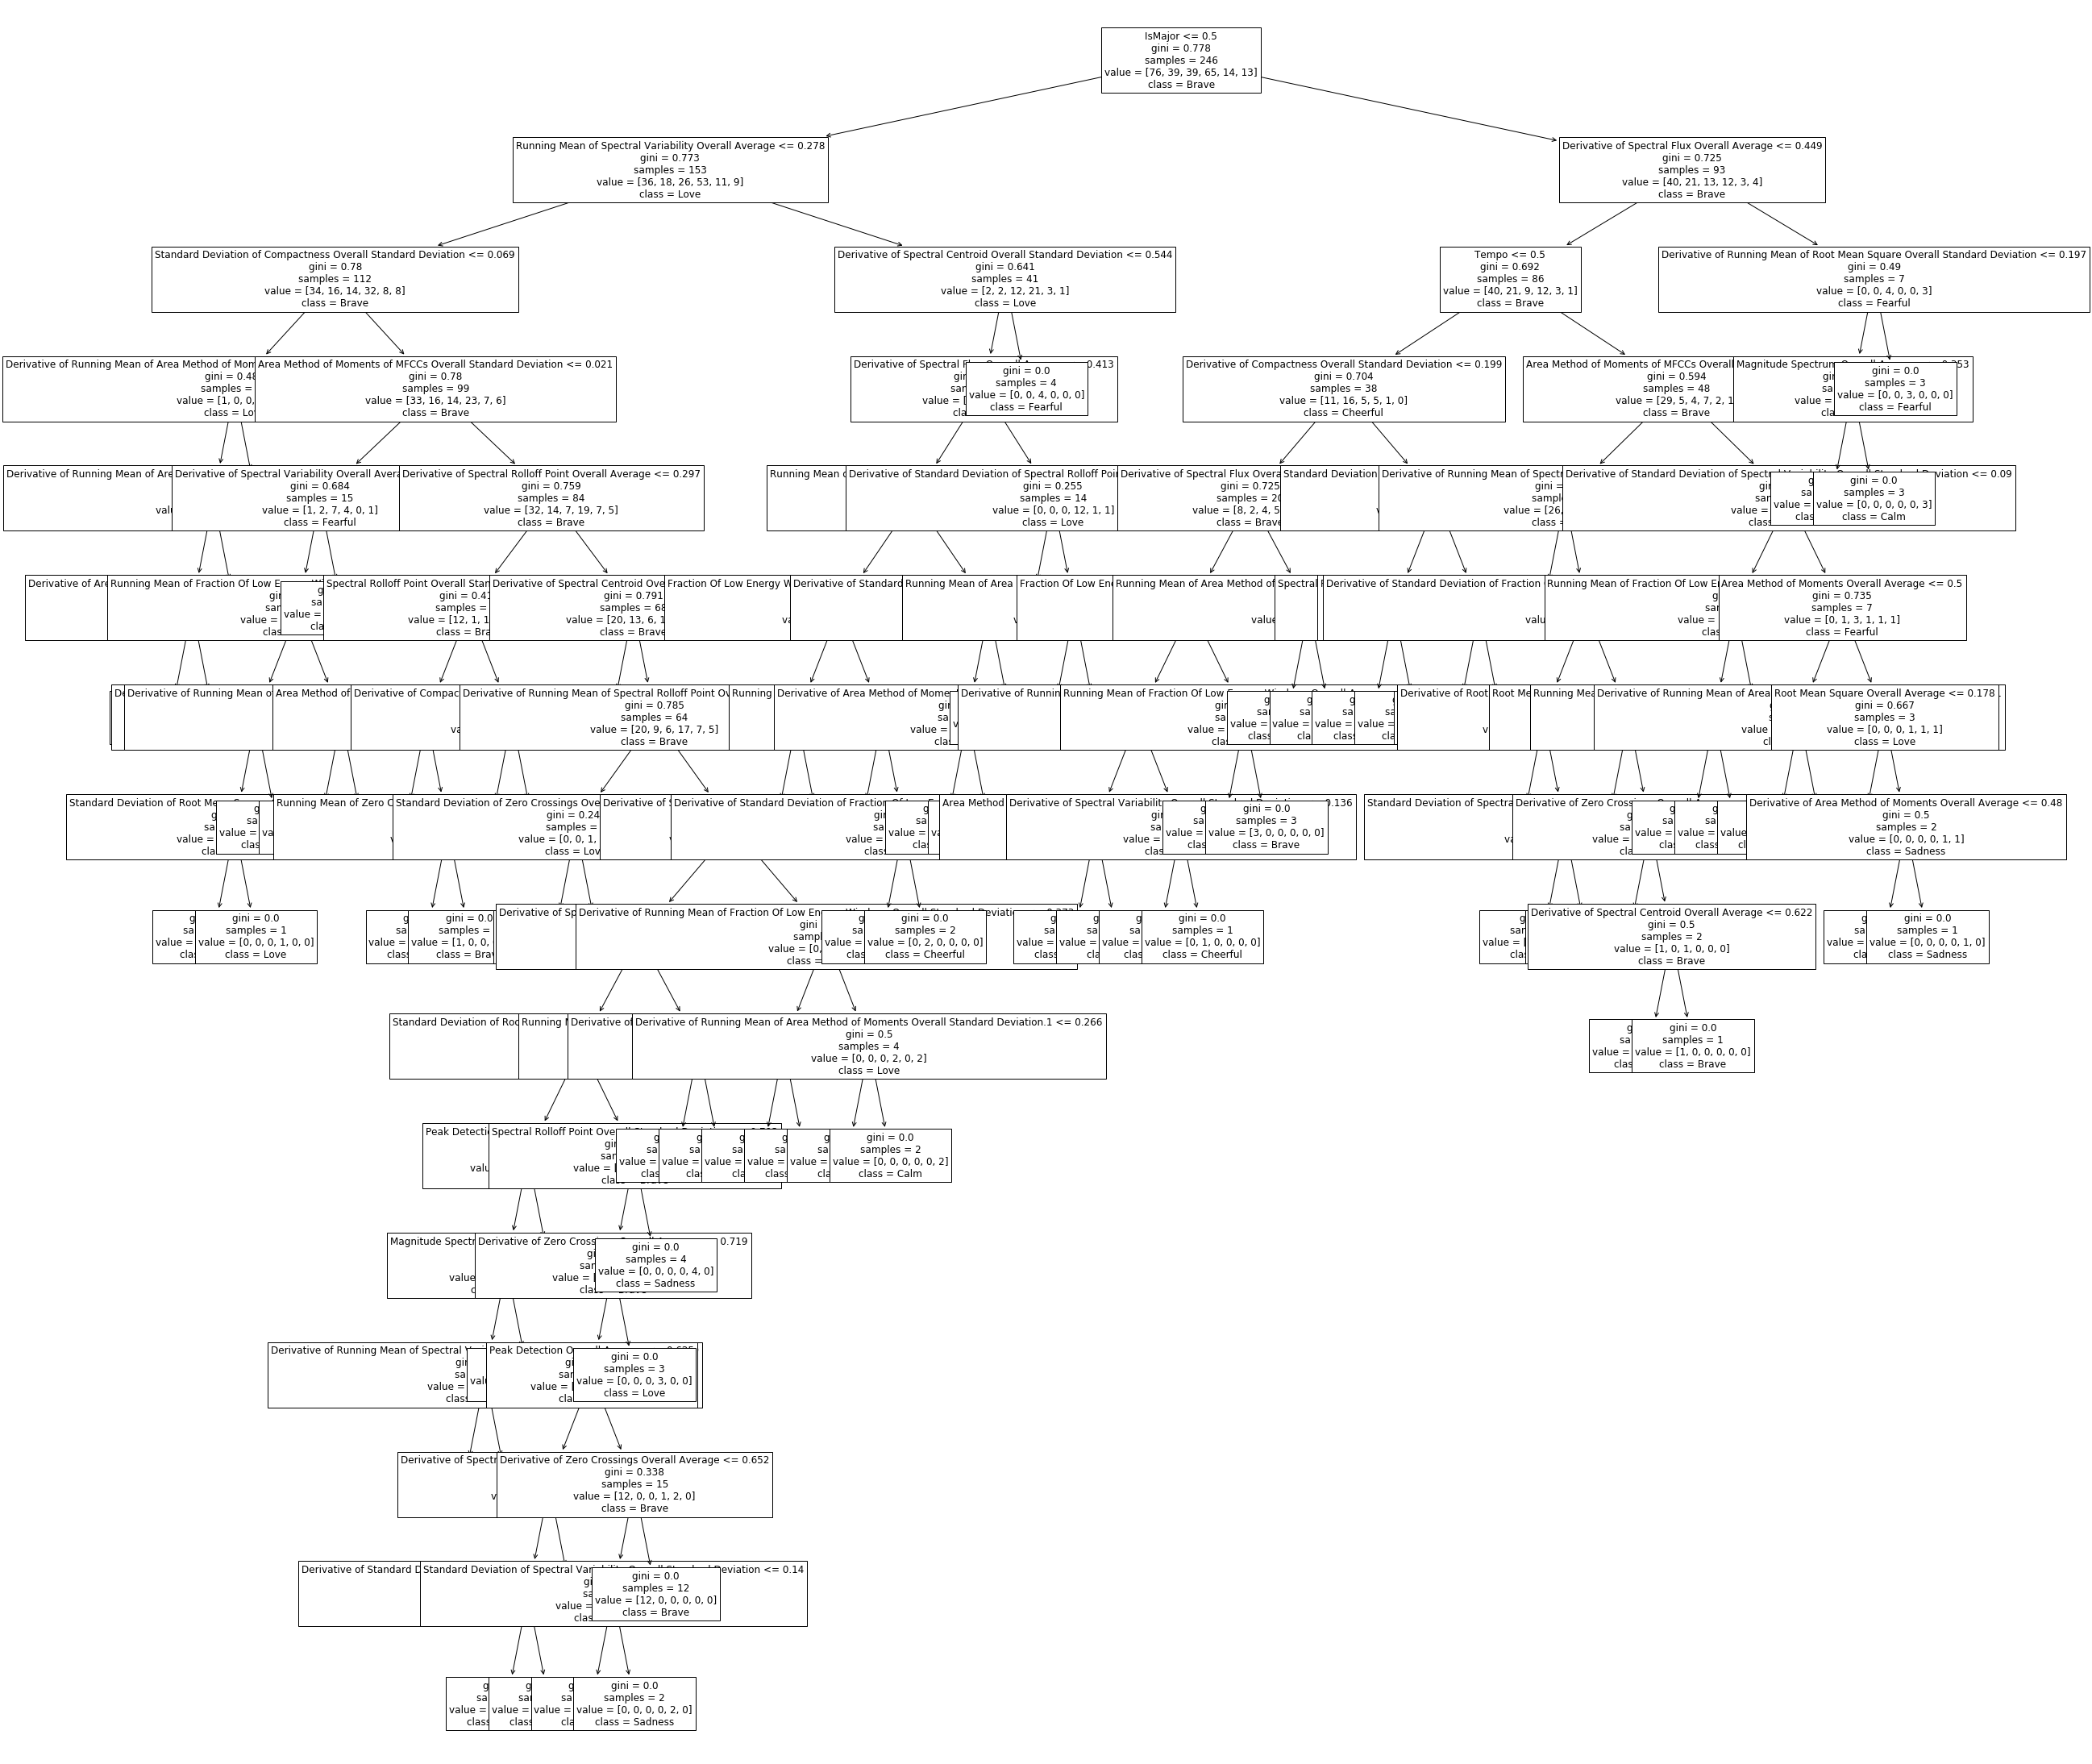

In [7]:
print_res("Vanilla",x_train,y_train,rscv)
disp_tree(dt,x_train,y_train,"TrainingSet (Labeled Only).csv")

Random Oversampling:
Best Score: 0.6645
criterion => entropy
max_depth => 9
min_samples_split => 0.011832014477136665
splitter => random
Splits: 5
Accuracy: 93.4211%


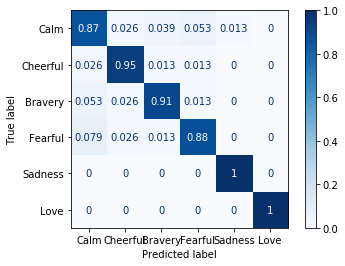

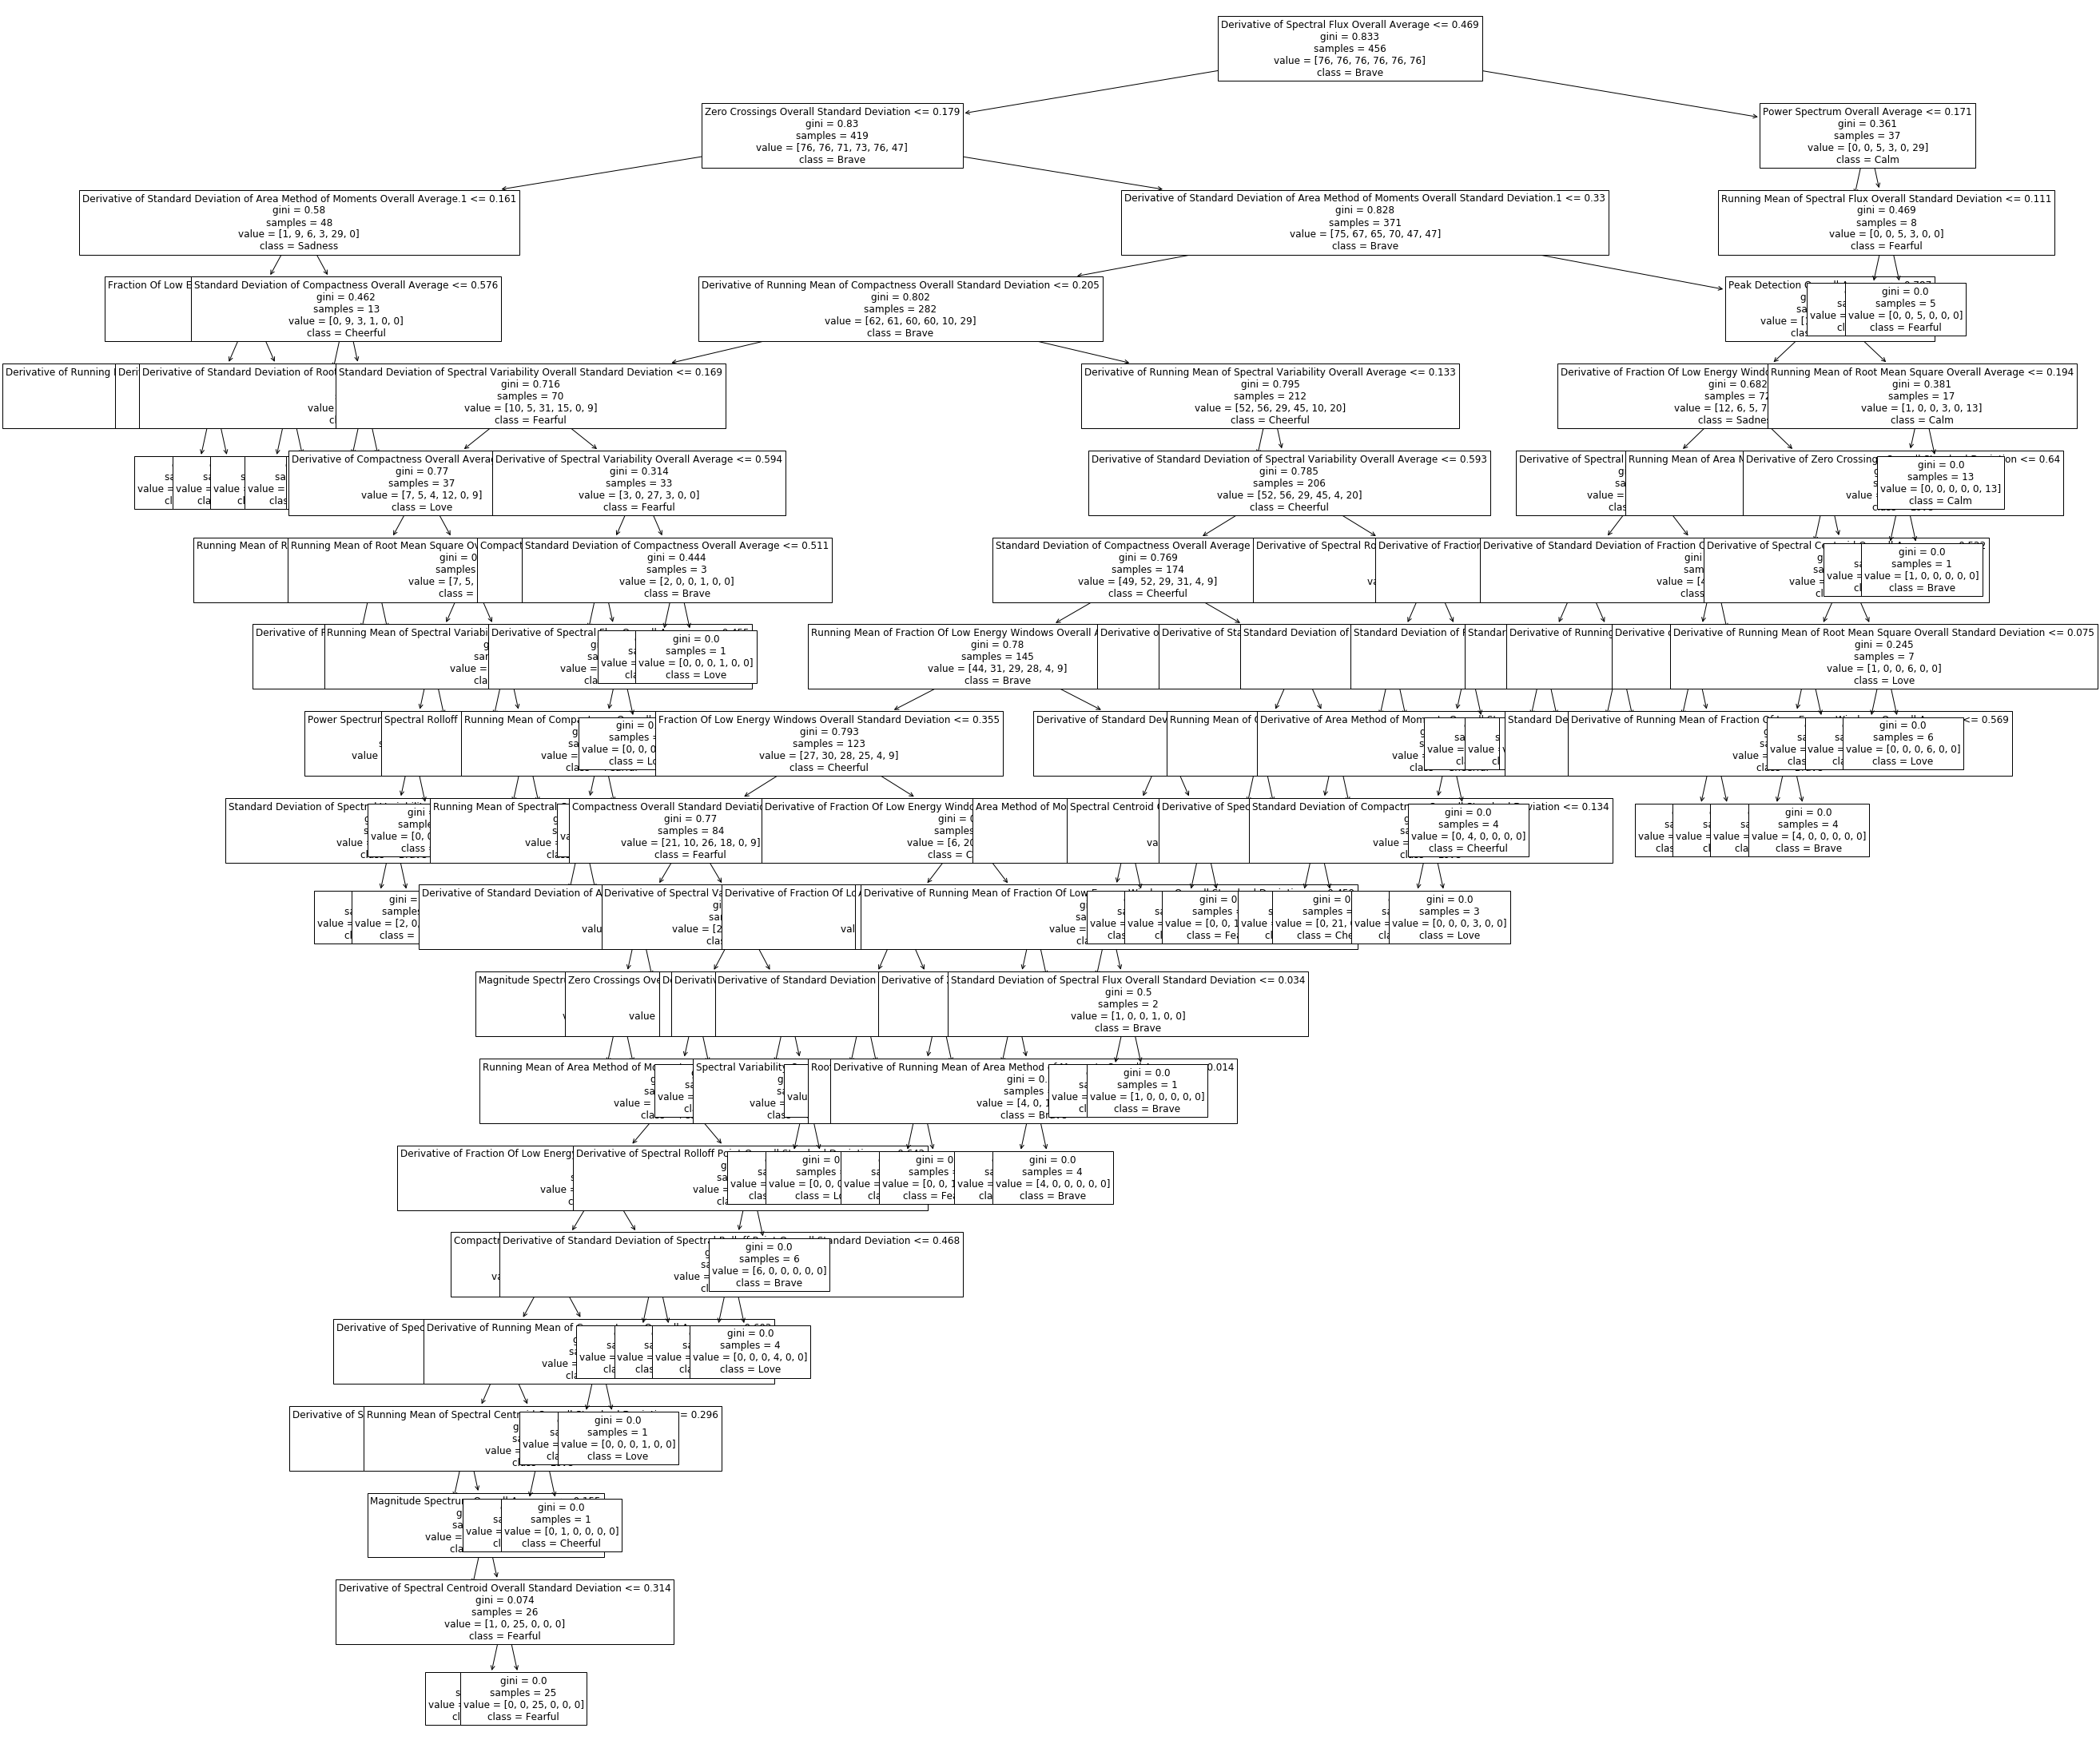

In [8]:
print_res("Random Oversampling",x_os,y_os,rscv)
disp_tree(dt,x_os,y_os,"TrainingSet (Labeled Only).csv")

SMOTE:
Best Score: 0.5265
criterion => entropy
max_depth => 9
min_samples_split => 0.011832014477136665
splitter => random
Splits: 5
Accuracy: 88.3772%


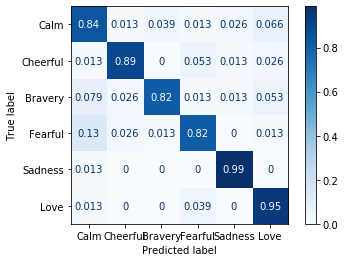

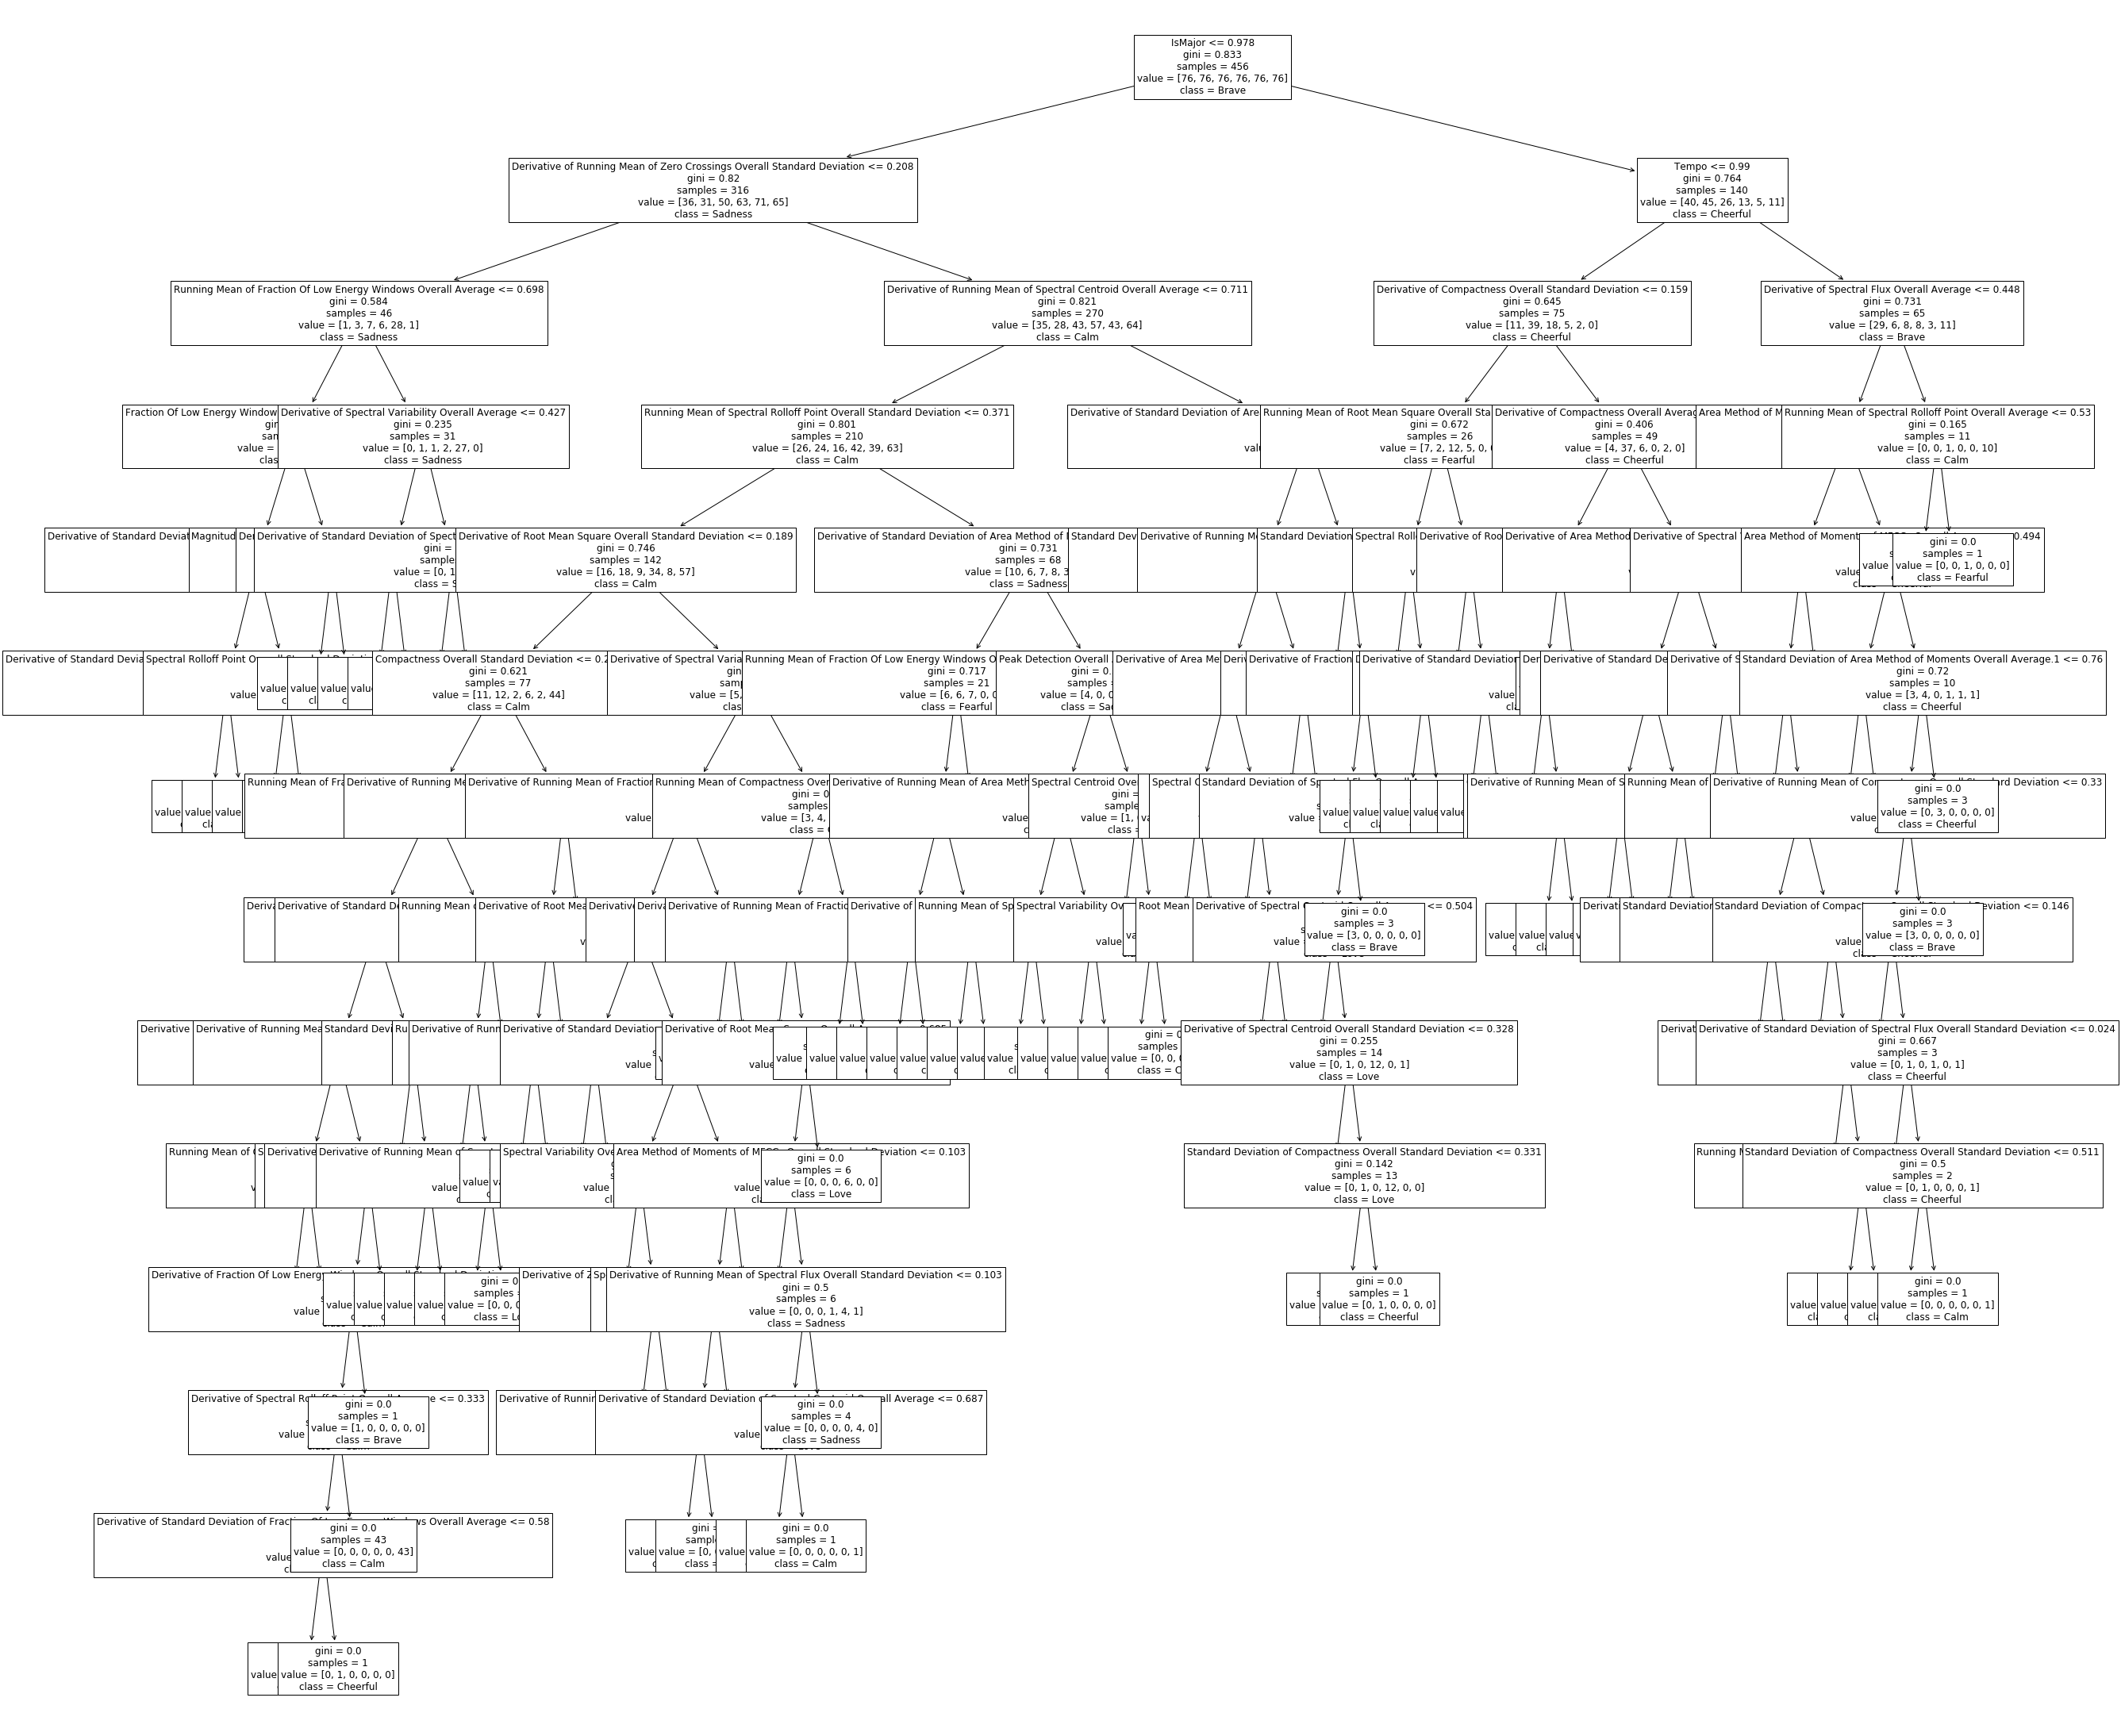

In [9]:
print_res("SMOTE",x_smote,y_smote,rscv)
disp_tree(dt,x_smote,y_smote,"TrainingSet (Labeled Only).csv")

In [11]:
# read unlabeled data
x_unlabeled = extract_data("TrainingSet (Unlabeled).csv",False)

(151, 325)
(151, 324)
(0,)


In [ ]:
# call predict() on x_unlabeled

In [ ]:
# build new training set with labeled samples (vanilla) concatenated with newly labeled samples from previous cell